# Loan Default Prediction Model
**Team**: Renaissance Technologies  
**Purpose**: Build predictive model for borrower default probability with logistic regression

## 1. Setup and Data Loading

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


In [27]:
# Load engineered dataset
df = pd.read_csv('dataset_with_features.csv')

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nTarget Variable Distribution:")
print(df['default'].value_counts())
print(f"\nDefault Rate: {df['default'].mean()*100:.2f}%")

df.head()

Dataset Shape: 89,999 rows × 81 columns

Target Variable Distribution:
default
0    85405
1     4594
Name: count, dtype: int64

Default Rate: 5.10%


,customer_id,application_id,application_hour,application_day_of_week,account_open_year,preferred_contact,referral_code,account_status_code,random_noise_1,num_login_sessions,...,recent_delinquency,credit_age_years,high_interest_flag,loan_to_income,is_mortgage,is_credit_card,total_risk_score,loan_purpose_target_enc,marketing_campaign_target_enc,state_target_enc
0,10000,620515,5,6,2013,Mail,REF0000,ACT-2,1.137099,13,...,0,22.8,1,0.286403,0,0,1,0.058875,0.061012,0.052888
1,10001,624978,4,2,2015,Phone,REF0000,ACT-3,-0.164932,6,...,0,3.5,0,3.985875,1,0,2,0.065684,0.051967,0.040979
2,10002,564658,10,3,2020,Phone,REF0000,ACT-3,0.526700,1,...,0,0.0,1,0.449254,0,0,0,0.043160,0.051199,0.053124
3,10003,621493,7,5,2010,Email,REF0000,ACT-1,-0.709779,4,...,0,9.0,1,0.277061,0,0,0,0.046427,0.049602,0.054630
4,10004,637785,1,2,2020,Mail,REF0000,ACT-3,-0.603132,6,...,0,8.0,0,0.292671,0,0,0,0.058208,0.048434,0.052772


## 2. Feature Selection and Preparation

In [28]:
# Define columns to exclude from modeling
exclude_cols = [
    'customer_id',           # Identifier
    'application_id',        # Identifier
    'default',               # Target variable
    'loan_officer_id',       # Too many unique values
    'marketing_campaign',    # Too many unique values
    'referral_code',         # Too many unique values
    'previous_zip_code',     # Too many unique values
]

# Separate numeric and categorical features
all_features = [col for col in df.columns if col not in exclude_cols]

numeric_features = df[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[all_features].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Feature Selection Summary")
print(f"{'='*60}")
print(f"Total features available: {len(all_features)}")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"\nCategorical Features:")
for feat in categorical_features:
    n_unique = df[feat].nunique()
    print(f"  {feat}: {n_unique} unique values")

Feature Selection Summary
Total features available: 74
Numeric features: 64
Categorical features: 10

Categorical Features:
  preferred_contact: 3 unique values
  account_status_code: 3 unique values
  employment_type: 4 unique values
  education: 5 unique values
  marital_status: 3 unique values
  loan_type: 3 unique values
  loan_purpose: 8 unique values
  origination_channel: 4 unique values
  state: 20 unique values
  credit_score_category: 4 unique values


In [29]:
# One-hot encode categorical features
print("Encoding categorical features...")

df_encoded = df.copy()

# One-hot encoding for categorical features
for feat in categorical_features:
    n_unique = df[feat].nunique()
    
    # Skip if too many categories
    if n_unique > 50:
        print(f"  Skipping {feat} ({n_unique} categories - too many)")
        continue
    
    # One-hot encode with drop_first to avoid multicollinearity
    dummies = pd.get_dummies(df[feat], prefix=feat, drop_first=True, dtype=int)
    df_encoded = pd.concat([df_encoded, dummies], axis=1)
    print(f"  ✓ {feat}: created {len(dummies.columns)} dummy variables")

# Drop original categorical columns
df_encoded = df_encoded.drop(columns=categorical_features)

print(f"\nDataset after encoding: {df_encoded.shape[0]:,} rows × {df_encoded.shape[1]} columns")

Encoding categorical features...
  ✓ preferred_contact: created 2 dummy variables
  ✓ account_status_code: created 2 dummy variables
  ✓ employment_type: created 3 dummy variables
  ✓ education: created 4 dummy variables
  ✓ marital_status: created 2 dummy variables
  ✓ loan_type: created 2 dummy variables
  ✓ loan_purpose: created 7 dummy variables
  ✓ origination_channel: created 3 dummy variables
  ✓ state: created 19 dummy variables
  ✓ credit_score_category: created 3 dummy variables

Dataset after encoding: 89,999 rows × 118 columns


## 3. Train/Test Split (Stratified)

In [30]:
# Prepare X (features) and y (target)
feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]
X = df_encoded[feature_cols].copy()
y = df_encoded['default'].copy()

print(f"Feature Matrix (X): {X.shape}")
print(f"Target Vector (y): {y.shape}")
print(f"\nFeatures being used: {len(feature_cols)}")

# Check for missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"\n Warning: {missing_count} missing values detected")
    print("Filling missing values with median...")
    X = X.fillna(X.median())
else:
    print("\nNo missing values in feature matrix")

Feature Matrix (X): (89999, 111)
Target Vector (y): (89999,)

Features being used: 111

No missing values in feature matrix


In [31]:
# Stratified train/test split
# Using stratify to maintain class distribution in both sets
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train/Test Split Summary")
print(f"{'='*60}")
print(f"Test Size: {TEST_SIZE*100:.0f}%")
print(f"Random State: {RANDOM_STATE}")
print(f"\nTraining Set:")
print(f"  Rows: {len(X_train):,}")
print(f"  Default Rate: {y_train.mean()*100:.2f}%")
print(f"  Class Distribution:")
for cls, count in y_train.value_counts().sort_index().items():
    pct = (count / len(y_train)) * 100
    print(f"    Class {cls}: {count:,} ({pct:.2f}%)")

print(f"\nTest Set:")
print(f"  Rows: {len(X_test):,}")
print(f"  Default Rate: {y_test.mean()*100:.2f}%")
print(f"  Class Distribution:")
for cls, count in y_test.value_counts().sort_index().items():
    pct = (count / len(y_test)) * 100
    print(f"Class {cls}: {count:,} ({pct:.2f}%)")

print(f"\n Stratification preserved class distribution in both sets")

Train/Test Split Summary
Test Size: 20%
Random State: 42

Training Set:
  Rows: 71,999
  Default Rate: 5.10%
  Class Distribution:
    Class 0: 68,324 (94.90%)
    Class 1: 3,675 (5.10%)

Test Set:
  Rows: 18,000
  Default Rate: 5.11%
  Class Distribution:
Class 0: 17,081 (94.89%)
Class 1: 919 (5.11%)

 Stratification preserved class distribution in both sets


## 4. Feature Scaling

Logistic Regression is sensitive to feature scales. We'll standardize all features to have mean=0 and std=1.

In [32]:
# Standardize features (fit on training set only)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier interpretation
X_train_scaled = pd.DataFrame(
    X_train_scaled, 
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete")
print(f"{'='*60}")
print(f"Scaler fitted on training set only")
print(f"Mean of scaled features: {X_train_scaled.mean().mean():.6f}")
print(f"Std of scaled features: {X_train_scaled.std().mean():.6f}")
print(f"\n Features standardized (mean=0, std=1)")

Feature Scaling Complete
Scaler fitted on training set only
Mean of scaled features: 0.000000
Std of scaled features: 1.000007

 Features standardized (mean=0, std=1)


## 5. Baseline Model: Logistic Regression


In [33]:
# Train logistic regression with balanced class weights


lr_model = LogisticRegression(
    class_weight='balanced',      # Handle class imbalance
    random_state=RANDOM_STATE,
    solver='lbfgs',               # Good for small to medium datasets
    n_jobs=-1                     # Use all CPU cores
)

lr_model.fit(X_train_scaled, y_train)

print("Model trained successfully")
print(f"\nModel Parameters:")
print(f"  Solver: {lr_model.solver}")
print(f"  Class Weight: balanced (handles imbalance)")
print(f"  Iterations: {lr_model.n_iter_[0]}")
print(f"  Converged: {lr_model.n_iter_[0] < lr_model.max_iter}")

Model trained successfully

Model Parameters:
  Solver: lbfgs
  Class Weight: balanced (handles imbalance)
  Iterations: 78
  Converged: True


## 6. Model Predictions and Evaluation

In [34]:
# Generate predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Generate probability predictions (for ROC-AUC)
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
train_roc_auc = roc_auc_score(y_train, y_train_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

train_pr_auc = average_precision_score(y_train, y_train_proba)
test_pr_auc = average_precision_score(y_test, y_test_proba)

print("Baseline Model Performance")
print(f"\nROC-AUC Scores:")
print(f"  Training Set: {train_roc_auc:.4f}")
print(f"  Test Set:     {test_roc_auc:.4f}")
print(f"  Difference:   {abs(train_roc_auc - test_roc_auc):.4f}")

print(f"\nPrecision-Recall AUC:")
print(f"  Training Set: {train_pr_auc:.4f}")
print(f"  Test Set:     {test_pr_auc:.4f}")

Baseline Model Performance

ROC-AUC Scores:
  Training Set: 0.8049
  Test Set:     0.8037
  Difference:   0.0012

Precision-Recall AUC:
  Training Set: 0.2514
  Test Set:     0.2545


In [35]:
# Detailed classification report for test set
print("\nDetailed Classification Report (Test Set)")
print(f"{'='*60}")
print(classification_report(y_test, y_test_pred, 
                          target_names=['No Default', 'Default'],
                          digits=4))


Detailed Classification Report (Test Set)
              precision    recall  f1-score   support

  No Default     0.9803    0.7402    0.8435     17081
     Default     0.1303    0.7236    0.2209       919

    accuracy                         0.7394     18000
   macro avg     0.5553    0.7319    0.5322     18000
weighted avg     0.9369    0.7394    0.8117     18000



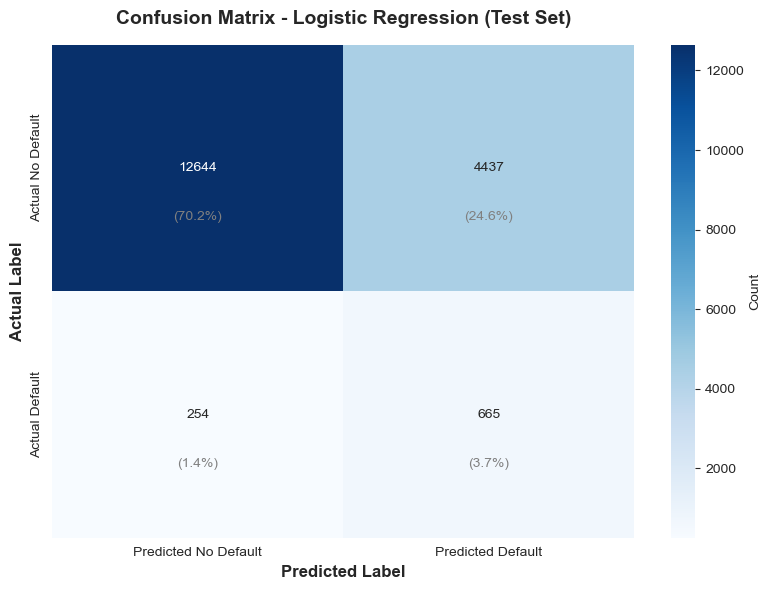


Confusion Matrix Breakdown:
  True Negatives (Correctly predicted no default):  12,644
  False Positives (Incorrectly predicted default):  4,437
  False Negatives (Missed defaults):                254
  True Positives (Correctly predicted default):     665


In [36]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Default', 'Predicted Default'],
            yticklabels=['Actual No Default', 'Actual Default'],
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_title('Confusion Matrix - Logistic Regression (Test Set)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Actual Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        pct = (cm[i, j] / total) * 100
        ax.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
               ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Correctly predicted no default):  {tn:,}")
print(f"  False Positives (Incorrectly predicted default):  {fp:,}")
print(f"  False Negatives (Missed defaults):                {fn:,}")
print(f"  True Positives (Correctly predicted default):     {tp:,}")

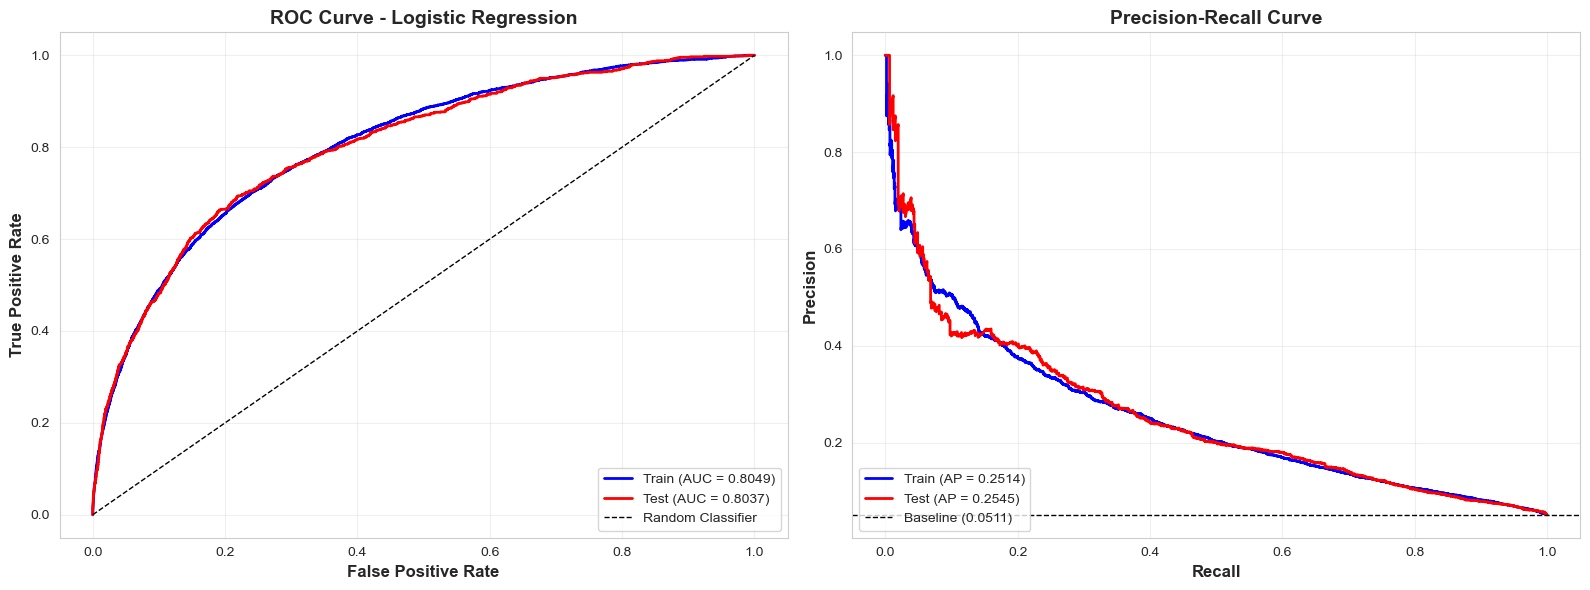

In [37]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1 = axes[0]
ax1.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_roc_auc:.4f})', 
         linewidth=2, color='blue')
ax1.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_roc_auc:.4f})', 
         linewidth=2, color='red')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

ax2 = axes[1]
ax2.plot(recall_train, precision_train, 
         label=f'Train (AP = {train_pr_auc:.4f})', linewidth=2, color='blue')
ax2.plot(recall_test, precision_test, 
         label=f'Test (AP = {test_pr_auc:.4f})', linewidth=2, color='red')
ax2.axhline(y=y_test.mean(), color='k', linestyle='--', 
           label=f'Baseline ({y_test.mean():.4f})', linewidth=1)
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance (Top Coefficients)

Interpreting logistic regression coefficients to understand which features drive default prediction.

Top 20 Most Important Features (by coefficient magnitude)
                      Feature  Coefficient
      loan_purpose_target_enc    -0.676877
                 credit_score    -0.428591
             state_target_enc    -0.396016
                     state_MI     0.346946
loan_purpose_Revolving Credit    -0.274571
               is_credit_card    -0.274571
       regional_median_income     0.269392
                     state_TN     0.257032
  loan_purpose_Major Purchase    -0.215311
                     state_FL     0.211684
                     state_OH     0.206118
           loan_type_personal     0.199269
                     state_MO     0.181719
        existing_monthly_debt    -0.177478
loan_purpose_Home Improvement    -0.175944
                     state_GA     0.167773
           loan_purpose_Other    -0.165593
                     state_VA     0.164165
                     state_NY     0.159687
          num_credit_accounts    -0.159349


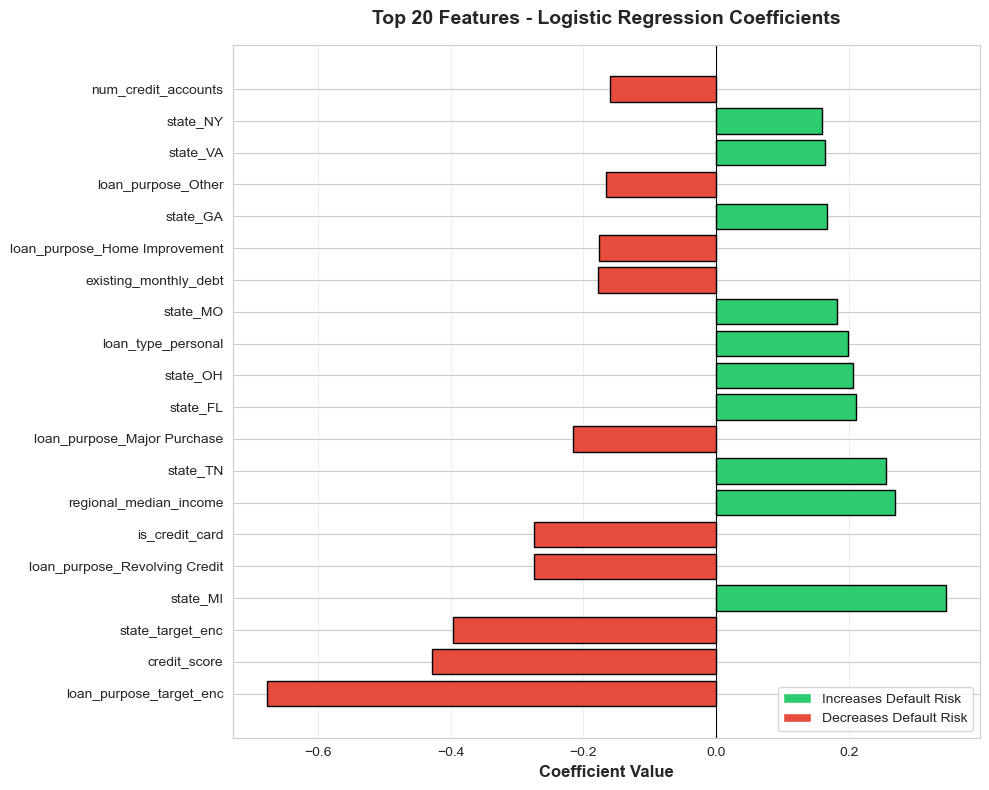

In [38]:
# Extract feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0]
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("Top 20 Most Important Features (by coefficient magnitude)")
print(f"{'='*60}")
print(feature_importance.head(20)[['Feature', 'Coefficient']].to_string(index=False))

# Visualize top coefficients
top_n = 20
top_features = feature_importance.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Logistic Regression Coefficients', 
             fontsize=14, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Increases Default Risk'),
    Patch(facecolor='#e74c3c', label='Decreases Default Risk')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()